# Object Recognition on RGB-D Object Dataset Using Traditional CV

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import Parallel, delayed
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Loading and Preprocessing

In [2]:
# Set environment variable for 20 cores
os.environ['LOKY_MAX_CPU_COUNT'] = '20'

# Define data directory and target image size
data_dir = "./data/rgbd-dataset"
image_size = (128, 128)

# --- Dataset Loading and Preprocessing ---
image_paths = []
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
for cls in class_names:
    cls_dir = os.path.join(data_dir, cls)
    for instance in os.listdir(cls_dir):
        inst_dir = os.path.join(cls_dir, instance)
        if not os.path.isdir(inst_dir):
            continue
        # Find matching RGB, depth, and mask files
        rgb_files = [os.path.join(inst_dir, f) for f in os.listdir(inst_dir) if f.endswith("_crop.png")]
        depth_files = [os.path.join(inst_dir, f) for f in os.listdir(inst_dir) if f.endswith("_depthcrop.png")]
        mask_files = [os.path.join(inst_dir, f) for f in os.listdir(inst_dir) if f.endswith("_maskcrop.png")]
        rgb_files.sort()
        depth_files.sort()
        mask_files.sort()
        for rgb_path, depth_path, mask_path in zip(rgb_files, depth_files, mask_files):
            instance_id = f"{cls}/{instance}"
            image_paths.append((rgb_path, depth_path, mask_path, cls, instance_id))

print(f"Found {len(image_paths)} images across {len(class_names)} classes.")

le = LabelEncoder()
le.fit(class_names)
y = [cls for (_, _, _, cls, _) in image_paths]
y_encoded = le.transform(y)

# Group images by instance and class
instance_to_indices = {}
instance_to_class = {}
for idx, (_, _, _, cls, instance) in enumerate(image_paths):
    instance_to_indices.setdefault(instance, []).append(idx)
    instance_to_class[instance] = le.transform([cls])[0]

instances = list(instance_to_indices.keys())
instance_classes = np.array([instance_to_class[inst] for inst in instances])

# Stratified split by class at the instance level
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(instances, instance_classes))

train_instances = [instances[i] for i in train_idx]
test_instances = [instances[i] for i in test_idx]

train_indices = [idx for inst in train_instances for idx in instance_to_indices[inst]]
test_indices = [idx for inst in test_instances for idx in instance_to_indices[inst]]

train_data = [image_paths[i] for i in train_indices]
train_labels = [y_encoded[i] for i in train_indices]
test_data = [image_paths[i] for i in test_indices]
test_labels = [y_encoded[i] for i in test_indices]

print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")
print(f"Unique classes in train: {len(np.unique(train_labels))}")
print(f"Unique classes in test: {len(np.unique(test_labels))}")

train_instance_set = set([data[4] for data in train_data])
test_instance_set = set([data[4] for data in test_data])
overlap = train_instance_set & test_instance_set
if overlap:
    raise ValueError(f"Data leakage detected: {len(overlap)} overlapping instances: {list(overlap)[:5]}")
else:
    print("No instance overlap detected between train and test sets.")


Found 88805 images across 20 classes.
Training samples: 71259, Test samples: 17546
Unique classes in train: 20
Unique classes in test: 20
No instance overlap detected between train and test sets.


## Feature Extraction with HOG

In [3]:
# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (16, 16),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

def extract_hog_features(rgb_path, depth_path, mask_path, size=image_size):
    """Load RGB and depth images, resize, and extract concatenated HOG features."""
    # Validate size parameter
    if not isinstance(size, tuple) or len(size) != 2:
        raise ValueError(f"Expected size to be a tuple of (width, height), got {size}")
    
    # Load and resize images
    img_rgb = cv2.imread(rgb_path)
    if img_rgb is None:
        raise ValueError(f"Failed to load RGB image: {rgb_path}")
    img_rgb = cv2.resize(img_rgb, size)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    
    img_depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
    if img_depth is None:
        raise ValueError(f"Failed to load depth image: {depth_path}")
    img_depth = cv2.resize(img_depth, size)
    # Ensure depth is single-channel grayscale
    if len(img_depth.shape) == 3:
        img_depth = cv2.cvtColor(img_depth, cv2.COLOR_BGR2GRAY)
    
    # Load and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask image: {mask_path}")
    mask = cv2.resize(mask, size)
    
    # Apply mask to images (set background to 0)
    img_gray_masked = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    img_depth_masked = cv2.bitwise_and(img_depth, img_depth, mask=mask)
    
    # Compute HOG on masked images
    hog_rgb = hog(img_gray_masked, **hog_params)
    hog_depth = hog(img_depth_masked, **hog_params)
    
    # Concatenate features
    return np.hstack((hog_rgb, hog_depth))

# Extract HOG features for all training and test images in parallel
train_hog = Parallel(n_jobs=-1)(
    delayed(extract_hog_features)(rgb, depth, mask, size=image_size)
    for (rgb, depth, mask, _, _) in train_data)
test_hog = Parallel(n_jobs=-1)(
    delayed(extract_hog_features)(rgb, depth, mask, size=image_size)
    for (rgb, depth, mask, _, _) in test_data)

X_train_hog = np.array(train_hog)
X_test_hog = np.array(test_hog)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

scaler_hog = StandardScaler()
X_train_hog = scaler_hog.fit_transform(X_train_hog)
X_test_hog = scaler_hog.transform(X_test_hog)

print(f"X_train_hog shape: {X_train_hog.shape}")
print(f"X_test_hog shape: {X_test_hog.shape}")

# Verify HOG feature size
expected_hog_size = 3528  # 1764 (RGB) + 1764 (Depth)
if X_train_hog.shape[1] != expected_hog_size:
    raise ValueError(f"Unexpected HOG feature size: {X_train_hog.shape[1]}, expected {expected_hog_size}")

X_train_hog shape: (71259, 3528)
X_test_hog shape: (17546, 3528)


## Feature Extraction with ORB

In [ ]:
def extract_orb_descriptors(rgb_path, mask_path):
    """Detect ORB keypoints and return descriptors for one image."""
    img = cv2.imread(rgb_path)
    if img is None:
        raise ValueError(f"Failed to load RGB image: {rgb_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask image: {mask_path}")
    # Resize images to ensure consistency 
    gray = cv2.resize(gray, image_size)
    mask = cv2.resize(mask, image_size)
    # Create ORB detector inside the function to avoid pickling
    orb = cv2.ORB_create(nfeatures=500)
    kp, des = orb.detectAndCompute(gray, mask)
    if des is None:
        return np.array([])  # If no keypoints, return empty
    return des

# Extract ORB descriptors for all training images in parallel
all_descriptors = Parallel(n_jobs=-1)(
    delayed(extract_orb_descriptors)(rgb, mask) for (rgb, _, mask, _, _) in train_data)

# Concatenate all descriptors from all images (filter out empties)
all_descriptors = np.vstack([des for des in all_descriptors if des.size != 0])
print(f"Total ORB descriptors collected: {all_descriptors.shape[0]}")

# Create a visual vocabulary (codebook) with K clusters
K = 50  # Number of visual words (hyperparameter)
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=10000)
kmeans.fit(all_descriptors)

def orb_bovw_histogram(rgb_path, mask_path):
    """Compute ORB descriptor histogram for one image using pre-trained kmeans."""
    des = extract_orb_descriptors(rgb_path, mask_path)
    if des.size == 0:
        return np.zeros(K)  # No keypoints found
    labels = kmeans.predict(des)
    hist, _ = np.histogram(labels, bins=np.arange(K+1))
    # Normalize histogram
    hist = hist.astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist

# Compute bag-of-words histograms for train and test sets
train_orb = Parallel(n_jobs=-1)(
    delayed(orb_bovw_histogram)(rgb, mask) for (rgb, _, mask, _, _) in train_data)
test_orb = Parallel(n_jobs=-1)(
    delayed(orb_bovw_histogram)(rgb, mask) for (rgb, _, mask, _, _) in test_data)

X_train_orb = np.array(train_orb)
X_test_orb = np.array(test_orb)

print(f"X_train_orb shape: {X_train_orb.shape}")
print(f"X_test_orb shape: {X_test_orb.shape}")
if X_train_orb.shape[1] != K:
    raise ValueError(f"Unexpected ORB feature size: {X_train_orb.shape[1]}, expected {K}")

Total ORB descriptors collected: 4018464
X_train_orb shape: (71259, 50)
X_test_orb shape: (17546, 50)


## Feature Extraction with SIFT

In [ ]:
def extract_sift_descriptors(rgb_path, depth_path, mask_path):
    """Extract SIFT descriptors from RGB and depth images."""
    # Create SIFT locally inside the function (works with parallelism)
    sift = cv2.SIFT_create()

    # Load images
    rgb_img = cv2.imread(rgb_path)
    if rgb_img is None:
        raise ValueError(f"Failed to load RGB image: {rgb_path}")
    rgb_gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    
    depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
    if depth_img is None:
        raise ValueError(f"Failed to load depth image: {depth_path}")
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask image: {mask_path}")

    # Resize images to ensure consistency 
    rgb_gray = cv2.resize(rgb_gray, image_size)
    depth_img = cv2.resize(depth_img, image_size)
    mask = cv2.resize(mask, image_size)

    # Compute SIFT descriptors
    kp1, des1 = sift.detectAndCompute(rgb_gray, mask)
    kp2, des2 = sift.detectAndCompute(depth_img, mask)

    # Handle cases where no descriptors are found
    if des1 is None:
        des1 = np.zeros((0, 128), dtype=np.float32)
    if des2 is None:
        des2 = np.zeros((0, 128), dtype=np.float32)

    # Combine descriptors from RGB and depth
    descriptors = np.vstack([des1, des2])
    return descriptors

# Extract only (rgb, depth, mask) pairs for descriptor extraction
train_pairs = [(rgb, depth, mask) for (rgb, depth, mask, _, _) in train_data]
test_pairs = [(rgb, depth, mask) for (rgb, depth, mask, _, _) in test_data]

# Parallel extraction of SIFT descriptors
train_descriptors = Parallel(n_jobs=-1)(
    delayed(extract_sift_descriptors)(rgb, depth, mask) for rgb, depth, mask in train_pairs)
test_descriptors = Parallel(n_jobs=-1)(
    delayed(extract_sift_descriptors)(rgb, depth, mask) for rgb, depth, mask in test_pairs)

# Sample up to 100 descriptors from each training image 
sampled_desc = []
for desc in train_descriptors:
    if desc.size > 0:
        idx = np.random.choice(desc.shape[0], size=min(100, desc.shape[0]), replace=False)
        sampled_desc.append(desc[idx])
sampled_desc = np.vstack(sampled_desc)

# Cluster into 500 visual words
kmeans = MiniBatchKMeans(n_clusters=500, random_state=42, batch_size=10000)
kmeans.fit(sampled_desc)

def compute_bovw_histogram(descriptors, kmeans):
    """Compute BoVW histogram for SIFT descriptors."""
    hist = np.zeros(kmeans.n_clusters, dtype=np.float32)
    if descriptors.size > 0:
        words = kmeans.predict(descriptors)
        for w in words:
            hist[w] += 1
        # L1-normalization
        if hist.sum() > 0:
            hist = hist / np.sum(hist)
    return hist

# Compute BoVW histograms for all train and test images
train_hist = Parallel(n_jobs=-1)(
    delayed(compute_bovw_histogram)(desc, kmeans) for desc in train_descriptors)
test_hist = Parallel(n_jobs=-1)(
    delayed(compute_bovw_histogram)(desc, kmeans) for desc in test_descriptors)

X_train_sift = np.array(train_hist)
X_test_sift = np.array(test_hist)

scaler_sift = StandardScaler()
X_train_sift = scaler_sift.fit_transform(X_train_sift)
X_test_sift = scaler_sift.transform(X_test_sift)

print(f"X_train_sift shape: {X_train_sift.shape}")
print(f"X_test_sift shape: {X_test_sift.shape}")
if X_train_sift.shape[1] != 500:
    raise ValueError(f"Unexpected SIFT feature size: {X_train_sift.shape[1]}, expected 500")

X_train_sift shape: (71259, 500)
X_test_sift shape: (17546, 500)


## Classification: HOG with Linear SVM

In [6]:
# Train a linear SVM on HOG features
svm = LinearSVC(C=0.1, max_iter=10000, random_state=42)
svm.fit(X_train_hog, y_train)
y_pred_hog = svm.predict(X_test_hog)
acc_hog = accuracy_score(y_test, y_pred_hog)
print(f"HOG+SVM test accuracy: {acc_hog:.2%}")

y_pred_train_hog = svm.predict(X_train_hog)
acc_train_hog = accuracy_score(y_train, y_pred_train_hog)
print(f"HOG+SVM training accuracy: {acc_train_hog:.2%}")

scores_hog = cross_val_score(svm, X_train_hog, y_train, cv=5, n_jobs=-1)
print(f"HOG+SVM 5-fold CV accuracy: {scores_hog.mean():.2%} ± {scores_hog.std():.2%}")

print("\nHOG+SVM Classification Report:")
print(classification_report(y_test, y_pred_hog, target_names=le.classes_))


HOG+SVM test accuracy: 84.09%
HOG+SVM training accuracy: 100.00%
HOG+SVM 5-fold CV accuracy: 93.05% ± 2.29%

HOG+SVM Classification Report:
                 precision    recall  f1-score   support

           ball       0.06      0.01      0.02       809
    bell_pepper       0.72      0.92      0.81       631
           bowl       0.67      0.80      0.73       582
     calculator       0.65      0.51      0.57       632
     cell_phone       0.74      0.83      0.78       544
     cereal_box       0.99      1.00      1.00       607
     coffee_mug       0.99      0.82      0.90      1347
    dry_battery       0.97      0.89      0.93       567
       food_bag       0.85      0.83      0.84      1574
       food_can       0.89      0.99      0.94       804
       food_cup       0.97      0.68      0.80       810
       food_jar       1.00      0.89      0.94       780
         garlic       0.47      1.00      0.64       798
     glue_stick       0.98      1.00      0.99       773
inst

## Classification: ORB with Random Forest

In [14]:
# Train a Random Forest on ORB features
rf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_orb, y_train)
y_pred_orb = rf.predict(X_test_orb)
acc_orb = accuracy_score(y_test, y_pred_orb)
print(f"ORB+RandomForest test accuracy: {acc_orb:.2%}")

y_pred_train_orb = rf.predict(X_train_orb)
acc_train_orb = accuracy_score(y_train, y_pred_train_orb)
print(f"ORB+RandomForest training accuracy: {acc_train_orb:.2%}")

scores_orb = cross_val_score(rf, X_train_orb, y_train, cv=5, n_jobs=-1)
print(f"ORB+RandomForest 5-fold CV accuracy: {scores_orb.mean():.2%} ± {scores_orb.std():.2%}")

print("\nORB+RandomForest Classification Report:")
print(classification_report(y_test, y_pred_orb, target_names=le.classes_))


ORB+RandomForest test accuracy: 31.57%
ORB+RandomForest training accuracy: 54.83%
ORB+RandomForest 5-fold CV accuracy: 33.07% ± 3.28%

ORB+RandomForest Classification Report:
                 precision    recall  f1-score   support

           ball       0.01      0.00      0.00       809
    bell_pepper       0.06      0.00      0.01       631
           bowl       0.50      0.43      0.46       582
     calculator       0.73      0.49      0.59       632
     cell_phone       0.00      0.00      0.00       544
     cereal_box       0.21      0.04      0.07       607
     coffee_mug       0.44      0.02      0.04      1347
    dry_battery       0.00      0.00      0.00       567
       food_bag       0.45      0.26      0.33      1574
       food_can       0.21      0.55      0.30       804
       food_cup       0.31      0.06      0.10       810
       food_jar       0.19      0.24      0.22       780
         garlic       0.05      0.08      0.06       798
     glue_stick       0.33

c:\Users\chira\anaconda3\envs\CVCenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chira\anaconda3\envs\CVCenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chira\anaconda3\envs\CVCenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classification: SIFT with SVM

In [8]:
# Train a linear SVM on SIFT features
svm = LinearSVC(C=0.1, random_state=42, max_iter=5000)
svm.fit(X_train_sift, y_train)
y_pred_sift = svm.predict(X_test_sift)
acc_sift = accuracy_score(y_test, y_pred_sift)
print(f"SIFT+SVM test accuracy: {acc_sift:.2%}")

y_pred_train_sift = svm.predict(X_train_sift)
acc_train_sift = accuracy_score(y_train, y_pred_train_sift)
print(f"SIFT+SVM training accuracy: {acc_train_sift:.2%}")

scores_sift = cross_val_score(svm, X_train_sift, y_train, cv=5, n_jobs=-1)
print(f"SIFT+SVM 5-fold CV accuracy: {scores_sift.mean():.2%} ± {scores_sift.std():.2%}")

print("\nSIFT+SVM Classification Report:")
print(classification_report(y_test, y_pred_sift, target_names=le.classes_))

SIFT+SVM test accuracy: 46.96%
SIFT+SVM training accuracy: 89.30%
SIFT+SVM 5-fold CV accuracy: 60.02% ± 3.97%

SIFT+SVM Classification Report:
                 precision    recall  f1-score   support

           ball       0.03      0.02      0.02       809
    bell_pepper       0.40      0.59      0.48       631
           bowl       0.09      0.09      0.09       582
     calculator       0.78      0.56      0.65       632
     cell_phone       0.45      0.65      0.53       544
     cereal_box       0.32      0.53      0.40       607
     coffee_mug       0.63      0.53      0.57      1347
    dry_battery       0.49      0.51      0.50       567
       food_bag       0.49      0.46      0.47      1574
       food_can       0.31      0.63      0.42       804
       food_cup       0.04      0.02      0.03       810
       food_jar       0.33      0.27      0.30       780
         garlic       0.50      0.43      0.46       798
     glue_stick       0.84      0.46      0.59       773
i

## Evaluation and Confusion Matrix

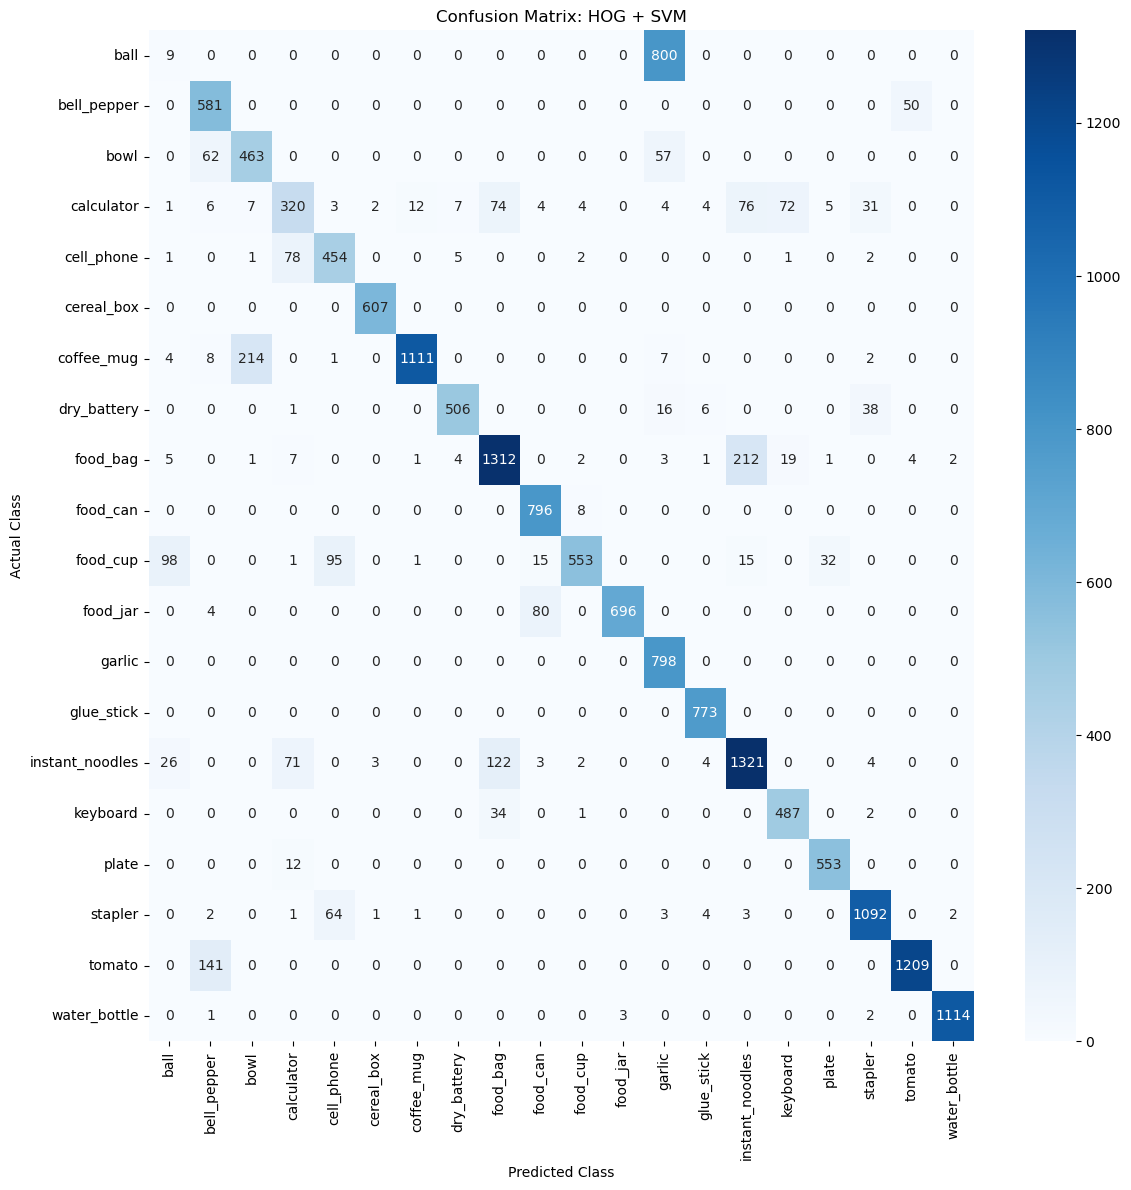

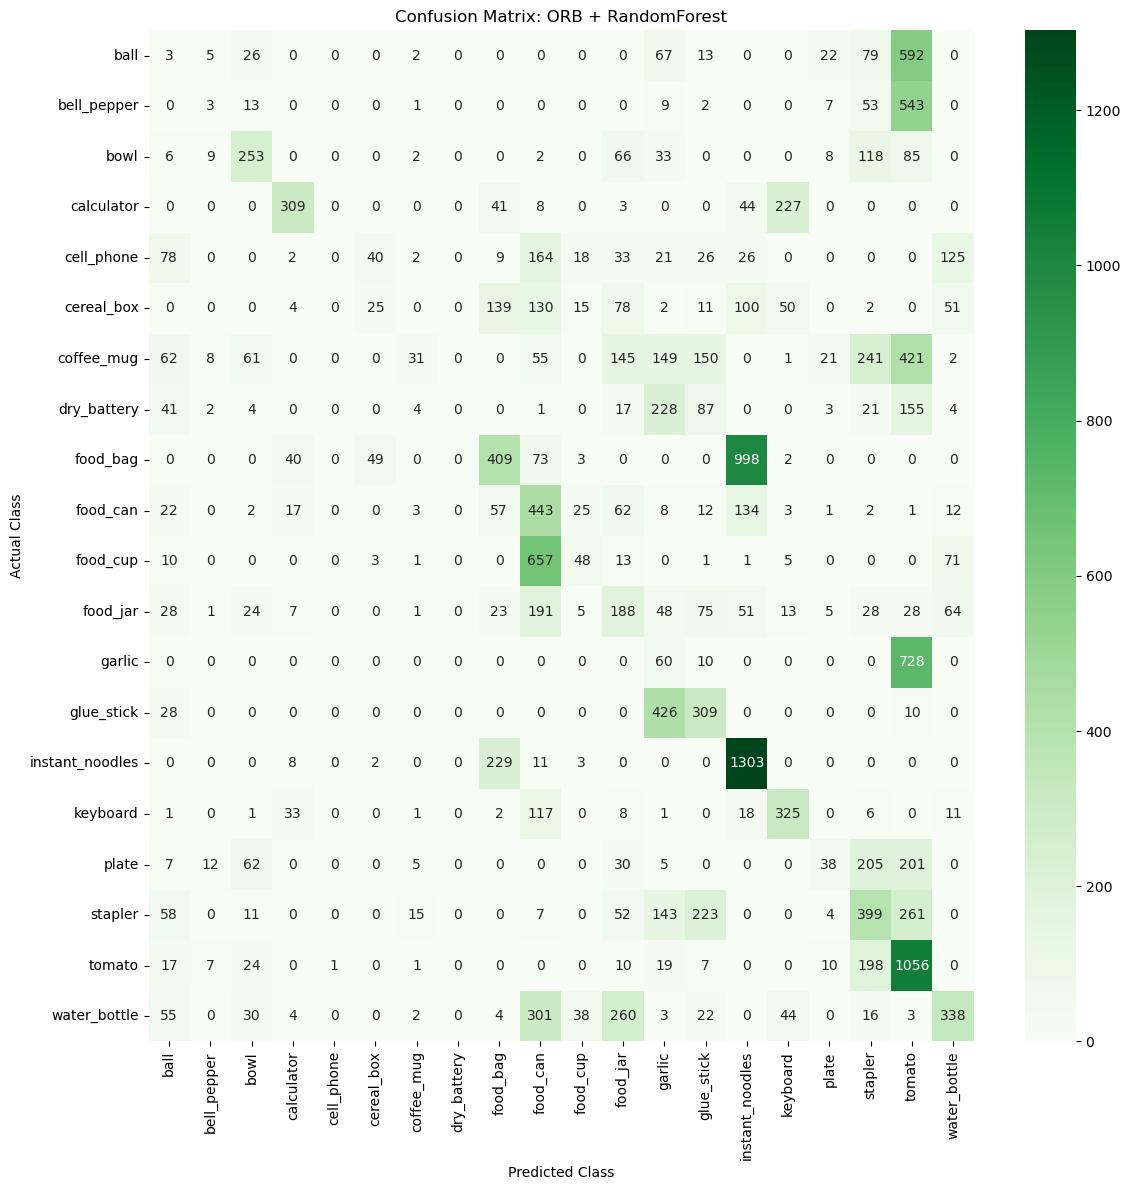

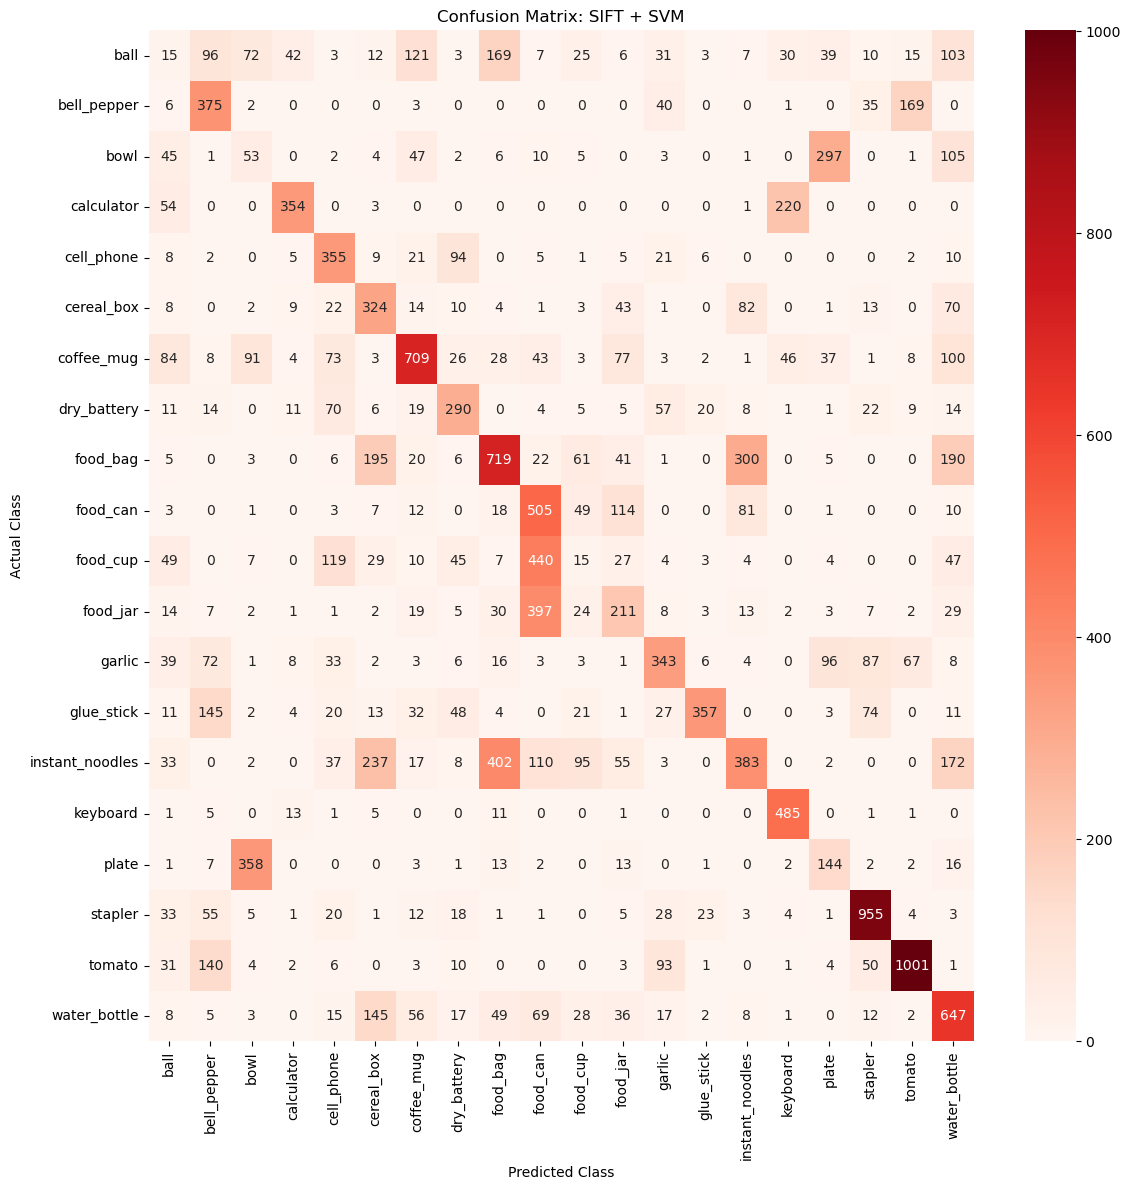

In [10]:
# Compute confusion matrices
cm_hog = confusion_matrix(y_test, y_pred_hog)
cm_orb = confusion_matrix(y_test, y_pred_orb)
cm_sift = confusion_matrix(y_test, y_pred_sift)

# Plot confusion matrix for HOG+SVM
plt.figure(figsize=(12,12))
sns.heatmap(cm_hog, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: HOG + SVM")
plt.ylabel("Actual Class"); plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

# Plot confusion matrix for ORB+RF
plt.figure(figsize=(12,12))
sns.heatmap(cm_orb, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: ORB + RandomForest")
plt.ylabel("Actual Class"); plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

# Plot confusion matrix for SIFT+SVM
plt.figure(figsize=(12,12))
sns.heatmap(cm_sift, annot=True, fmt="d", cmap="Reds",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: SIFT + SVM")
plt.ylabel("Actual Class"); plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()
